## Give Me The Next AAA Title
# Predictive Modeling
### Movie Profitability Prediction Based on Trailer Viewership
****

<br>
by Dustin Reyes
<br>
<br>
Prepared for:
<br>
Mynt (Globe Fintech Innovations, Inc.)
<br>
<br>

The purpose of this notebook is to identify if movie success in terms of profitability can be observed through trailer popularity through social media sites which in this case is Youtube. Youtube is deemed as the premiere video playback platform and content creation site in the world. It is by no-means an important outlet for marketing executives to showcase a movie for the public to see. This notebook uses data from TMDB (The Movie Database) alongside data gathered through Youtube API, OMDB API and data scraped from The Numbers to predict if a movie will be profitable based on Youtube Trailer Viewership.

In [40]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, make_scorer, accuracy_score
from collections import Counter
from xgboost import XGBClassifier, plot_importance


import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

In [41]:
cols1 = ['id', 'imdbId', 'numlang', 'cn', 'da', 'de',
         'en', 'es', 'fr', 'hi', 'it', 'ja', 'ko', 'ml', 'ru', 'ta',
         'zh']
df1 = pd.read_csv('data2/languages_parsed.csv', usecols=cols1)
df2 = pd.read_csv('data2/dategenre_parse.csv')

In [42]:
df1['id'] = df1['id'].astype('str')
df2['id'] = df2['id'].astype('str')

In [43]:
df3 = pd.merge(df2, df1, on='id')

In [44]:
df3.head()

,adult,budget,id,original_language,production_countries,revenue,runtime,spoken_languages,views,likes,...,es,fr,hi,it,ja,ko,ml,ru,ta,zh
0,False,30000000,862,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",8050136,6330,...,0,0,0,0,0,0,0,0,0,0
1,False,65000000,8844,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",83048,70,...,0,0,0,0,0,0,0,0,0,0
2,False,16000000,31357,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",104948,0,...,0,0,0,0,0,0,0,0,0,0
3,False,60000000,949,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",32419,119,...,0,0,0,0,0,0,0,0,0,0
4,False,35000000,9091,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",6162,12,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df3.columns

Index(['adult', 'budget', 'id', 'original_language', 'production_countries',
       'revenue', 'runtime', 'spoken_languages', 'views', 'likes', 'dislikes',
       'n_trailers', 'daysStart', 'dayInYear', 'Foreign', 'TV Movie',
       'History', 'Thriller', 'Science Fiction', 'Music', 'Romance', 'Comedy',
       'Mystery', 'Fantasy', 'Horror', 'Documentary', 'Western', 'Adventure',
       'Action', 'Animation', 'Family', 'Crime', 'Drama', 'War', 'imdbId',
       'numlang', 'cn', 'da', 'de', 'en', 'es', 'fr', 'hi', 'it', 'ja', 'ko',
       'ml', 'ru', 'ta', 'zh'],
      dtype='object')

In [46]:
cols_drop1 = ['original_language',
              'production_countries', 'spoken_languages',
             'imdbId']
df3.drop(cols_drop1, axis=1, inplace=True)

In [47]:
df3.head()

,adult,budget,id,revenue,runtime,views,likes,dislikes,n_trailers,daysStart,...,es,fr,hi,it,ja,ko,ml,ru,ta,zh
0,False,30000000,862,373554033.0,81.0,8050136,6330,1965,3,29484,...,0,0,0,0,0,0,0,0,0,0
1,False,65000000,8844,262797249.0,104.0,83048,70,14,1,29530,...,0,0,0,0,0,0,0,0,0,0
2,False,16000000,31357,81452156.0,127.0,104948,0,0,1,29537,...,0,0,0,0,0,0,0,0,0,0
3,False,60000000,949,187436818.0,170.0,32419,119,1,1,29530,...,0,0,0,0,0,0,0,0,0,0
4,False,35000000,9091,64350171.0,106.0,6162,12,3,2,29537,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df3 = df3.replace(r'^\s*$', np.nan, regex=True)

In [49]:
df3.dropna(inplace = True)

To define profitability, we use the Return of Investment as the numerical quantity to describe a movie's profitability. This meant subtracting the investment/budget allocated for a movie to its revenue then dividing it to the investment allocated. The main downside of this calculation is that in the Film industry, there are typically more factors to consider in terms of ROI but this basic calculation should suffice for now. A movie was then deemed profitable if its ROI is greater than or equal to two.

In [51]:
df3['ROI'] = (df3['revenue'] - df3['budget'])/df3['budget']

In [52]:
df3['profitability'] = np.where(df3['ROI'] >= 2, 1, 0)

In [53]:
df3['profitability'].value_counts()

0    3133
1    1823
Name: profitability, dtype: int64

In [54]:
df3.head()

,adult,budget,id,revenue,runtime,views,likes,dislikes,n_trailers,daysStart,...,hi,it,ja,ko,ml,ru,ta,zh,ROI,profitability
0,False,30000000,862,373554033.0,81.0,8050136,6330,1965,3,29484,...,0,0,0,0,0,0,0,0,11.451801,1
1,False,65000000,8844,262797249.0,104.0,83048,70,14,1,29530,...,0,0,0,0,0,0,0,0,3.043035,1
2,False,16000000,31357,81452156.0,127.0,104948,0,0,1,29537,...,0,0,0,0,0,0,0,0,4.090760,1
3,False,60000000,949,187436818.0,170.0,32419,119,1,1,29530,...,0,0,0,0,0,0,0,0,2.123947,1
4,False,35000000,9091,64350171.0,106.0,6162,12,3,2,29537,...,0,0,0,0,0,0,0,0,0.838576,0


## 1. Exploratory Data Analysis

### 1.1. Class Distribution

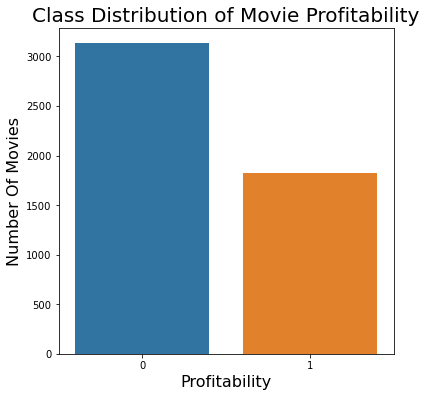

In [56]:
plt.figure(figsize=(6, 6))
sns.countplot(df3['profitability'])
plt.title('Class Distribution of Movie Profitability', fontsize=20)
plt.xlabel('Profitability', fontsize=16)
plt.ylabel('Number Of Movies', fontsize=16)
plt.show()

From the graph above, it can be seen that there is a slight imbalance to the data and this must be taken care of in order to remove biases during the inference of output.

### 1.2. Revenue Distribution

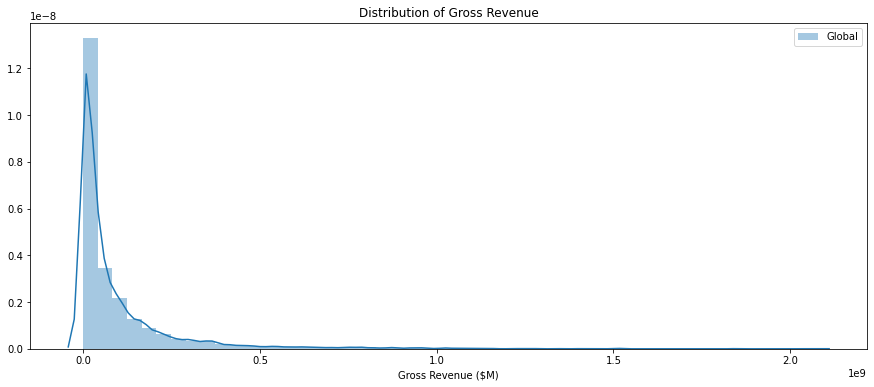

In [18]:
fig = plt.figure(figsize = (15, 6)) # set figure size

# plot distribution plot of global gross revenue 
sns.distplot(df3['revenue'], label = 'Global') 

plt.title("Distribution of Gross Revenue")
plt.xlabel("Gross Revenue ($M)")
plt.legend() # add legend
plt.show()

We can see that it is strongly right-skewed, it is a pretty usual trend for income data. Taking the log transformation of this data can help us visualize what’s happening in the dense area more clearly.

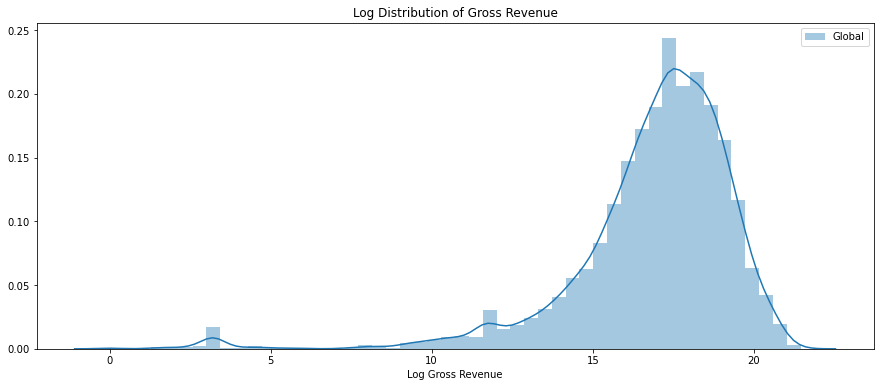

In [19]:
fig = plt.figure(figsize = (15, 6))

# taking a natural log of revenue
sns.distplot(np.log(df3['revenue']), label = 'Global') 
plt.title("Log Distribution of Gross Revenue")
plt.xlabel("Log Gross Revenue")
plt.legend()

#fig.savefig("filename.png")

plt.show()

### 1.3. Budget to Revenue Relationship

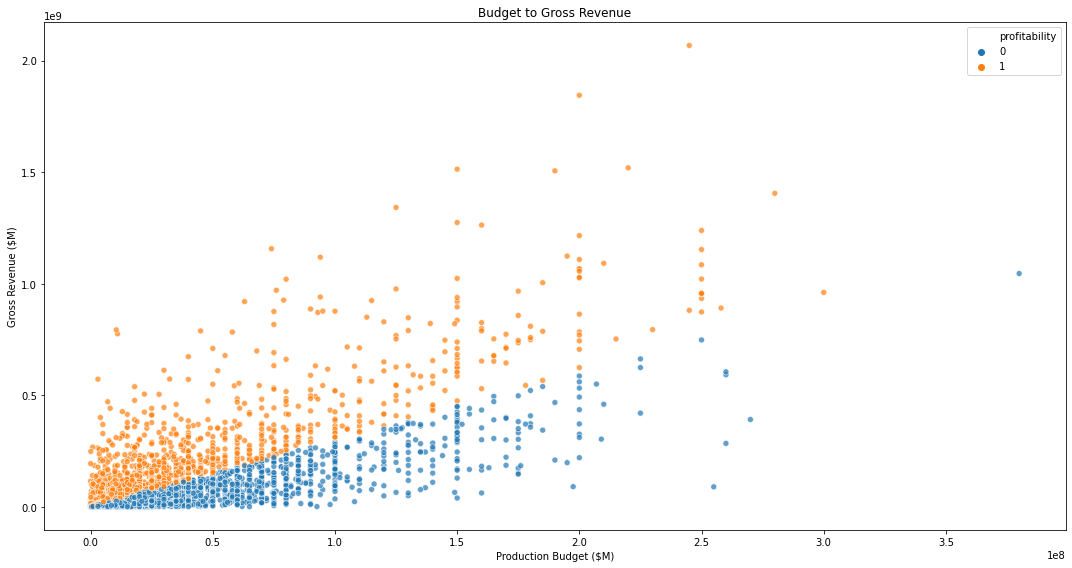

In [20]:
fig = plt.figure(figsize=(15, 8))

# plotting two scatterplots with 70% transparency.
sns.scatterplot(x='budget', y='revenue', hue = 'profitability', alpha=0.7, data=df3)

plt.title("Budget to Gross Revenue")
plt.ylabel("Gross Revenue ($M)")
plt.xlabel("Production Budget ($M)")
plt.legend()

# matplotlib's tight_layout function magically fit elements within the figure
# so it does not get cropped when you save it out.
plt.tight_layout()

# plt.savefig("filename.png")

plt.show()

It seems like a high budget does not always lead to high revenue though this was uncommon. Most movies with high budgets tend to have better gross revenue as the budget allocation can be divided into several components such as marketing budget, VFX budget, Quality Assurance, Actor budgets and so on.  Also, some movies yield high revenues with relatively lower budgets when it targets the global market.

### 1.4. Correlations

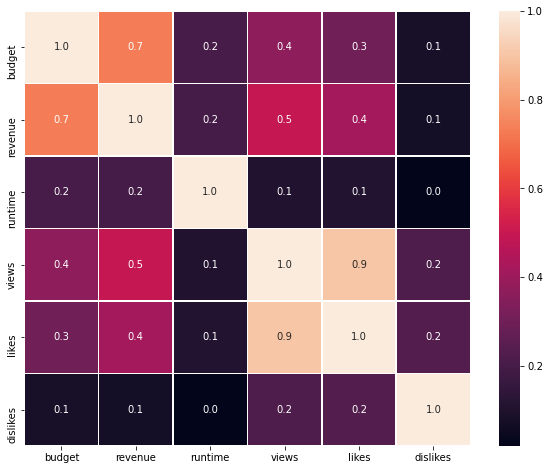

In [22]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df3[['budget', 'revenue', 'runtime', 'views', 'likes',
                 'dislikes']].corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
# sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)

Observations for these are the ff:
1. Revenue is positively correlated with budget therefore a high budget movie is more likely to generate more revenue than a low budget movie.
2. Views and Likes from Youtube trailers were also positively correlated with a movie budget. These movies most likely has more production values in terms of effects, CGI, and actors thus garnering more views and likes.
3. Surprisingly, movie runtime is has a low positive correlation with budget. This might mean budget cuts due to estimated runtime of a movie.
4. Likes and Views are highly positively correlated. However, this correlation can be biased as the distribution of likes and dislikes with respect to views is highly imbalanced.

### 1.5. Proportionality Chance Criterion

In [23]:
# Class count
count_class_0, count_class_1 = df3['profitability'].value_counts()

# Divide by class
df_class_0 = df3[df3['profitability'] == 0]
df_class_1 = df3[df3['profitability'] == 1]

In [24]:
# Resample the majority class into the minority class
df_class_0_under = df_class_0.sample(count_class_1)
df3 = pd.concat([df_class_0_under, df_class_1], axis=0)

Division per class:       0
0  1823
1  1823

1.25 * Proportion Chance Criterion: 62.5%


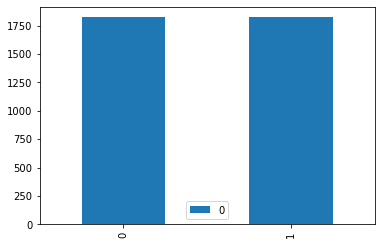

In [25]:
state_counts = Counter(df3['profitability'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar')

num = (df_state[0]/df_state[0].sum())**2
print("Division per class: {}\n".format(df_state))
print("1.25 * Proportion Chance Criterion: {}%".format(1.25*100*num.sum()))

The proportionality chance criterion specifies if our model can be considered as an effective predictive analytics model. This does not guarantee generalization on the other hand and only serves as the baseline.

### 2.0. Modeling

In [26]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
#cl7 = SVC(kernel='poly', degree=3)
cl8 = RandomForestClassifier(n_jobs=-1)
cl9 = GradientBoostingClassifier()
cl10 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))


kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)
max_depthlist = [3, 4, 6]
max_featureslist = [1, 2, 3, 4]
n_estimatorslist = [100, 200, 300]
learningrate_list = [.2, 0.1, 0.02, 0.01]

estimators = [('KNN', cl1, {'n_neighbors': kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C': C_list}),
              ('Logistic Regression (L2)', cl3, {'C': C_list}),
              ('Linear SVM (L1)', cl4, {'C': C_list}),
              ('Linear SVM (L2)', cl5, {'C': C_list}),
              ('Random Forest Classifier', cl8, {'n_estimators': n_estimatorslist,
                                                 'max_depth': max_depthlist,
                                                 'max_features': max_featureslist}),
              ('Gradient Boosting Classifier', cl9, {'n_estimators': n_estimatorslist,
                                                     'max_depth': max_depthlist,
                                                     'learning_rate': learningrate_list}),
              ('AdaBoost Classifier', cl10, {'n_estimators': n_estimatorslist,
                                             'learning_rate': learningrate_list})]

In [27]:
dropcols = ['adult','id','profitability', 'TV Movie', 'revenue', 'revenue', 'ROI']
X = df3.drop(dropcols, axis=1)
y = df3['profitability']

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,
                                                  random_state=15)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [29]:
models = {}
for est in estimators:
    print(f'Training {est}\n')
    gs_cv = GridSearchCV(est[1], param_grid=est[2], n_jobs=-1)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

Training ('KNN', KNeighborsClassifier(n_jobs=-1), {'n_neighbors': range(1, 31)})

Training ('Logistic Regression (L1)', LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', solver='liblinear'), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})



D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training ('Logistic Regression (L2)', LogisticRegression(max_iter=1000, n_jobs=-1), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})

Training ('Linear SVM (L1)', LinearSVC(dual=False, max_iter=10000, penalty='l1'), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})

Training ('Linear SVM (L2)', LinearSVC(max_iter=10000), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})



D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training ('Random Forest Classifier', RandomForestClassifier(n_jobs=-1), {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 6], 'max_features': [1, 2, 3, 4]})

Training ('Gradient Boosting Classifier', GradientBoostingClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 6], 'learning_rate': [0.2, 0.1, 0.02, 0.01]})

Training ('AdaBoost Classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)), {'n_estimators': [100, 200, 300], 'learning_rate': [0.2, 0.1, 0.02, 0.01]})



In [30]:
cols = ['Machine Learning Method', 'Training Accuracy', 'Test Accuracy',
        'Best Parameter', 'Top Predictor']
df_results = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    try:
        top = X.columns[np.argmax(
            np.abs(models[m].best_estimator_.coef_.T.mean(axis=1)))]
    except AttributeError:
        try:
            top = X.columns[
                np.argmax(np.abs(models[m].best_estimator_.feature_importances_))]
        except AttributeError:
            top = np.nan
    except AttributeError:
        top = np.nan

    df_results.loc[i] = [m,
                  models[m].best_estimator_.score(X_train, y_train),
                  models[m].best_estimator_.score(X_val, y_val),
                  models[m].best_params_,
                  top]

In [31]:
df_results

,Machine Learning Method,Training Accuracy,Test Accuracy,Best Parameter,Top Predictor
0,KNN,0.675567,0.605263,{'n_neighbors': 8},NaN
1,Logistic Regression (L1),0.649232,0.660088,{'C': 46.41588833612782},dislikes
2,Logistic Regression (L2),0.648500,0.661184,{'C': 7742.636826811277},dislikes
3,Linear SVM (L1),0.649598,0.664474,{'C': 3.593813663804626},dislikes
4,Linear SVM (L2),0.649232,0.664474,{'C': 46.41588833612782},dislikes
5,Random Forest Classifier,0.721287,0.657895,"{'max_depth': 6, 'max_features': 2, 'n_estimat...",daysStart
6,Gradient Boosting Classifier,0.825165,0.671053,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",daysStart
7,AdaBoost Classifier,0.704828,0.664474,"{'learning_rate': 0.2, 'n_estimators': 200}",dayInYear


In [32]:
df_results.iloc[6]['Best Parameter']

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In terms of test accuracy, Gradient Boosting Classifier gave the best performance. However, in terms of generalization, I would go with Random Forest Classifier as it has a lesser tendency to overfit in this use case.

In [33]:
model = GradientBoostingClassifier(
    max_depth=4, learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)
print(model.score(X_val, y_val))
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# plot graph of feature importances for better visualization
feat_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns = ['importance'])
feat_importances.sort_values(by = 'importance', ascending = False, inplace = True)

0.6710526315789473


In [34]:
feat_importances = feat_importances.head(10)

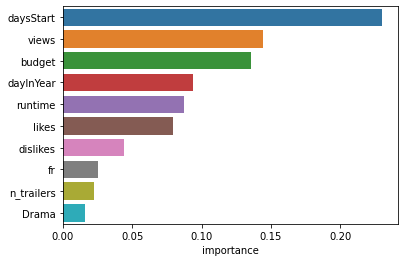

In [35]:
sns.barplot(x="importance", y=feat_importances.index, data=feat_importances)

The most important feature was how recently the movie was released (daysStart), relative to the earliest release date in our data. This idea makes sense because with technological progress, movie budgets have gone up and filmmakers can depict certain scenes more graphically and realistically. People globally also have more purchasing power, allowing them to spend more on watching movies.

However, it was really interesting that an important feature was which day in the year a movie was released. This means that temporal patterns should be considered when releasing a movie as more people can either have more free time or have the capacity to watch more films than other days.

Also, the 3 features we extracted from YouTube data are among the top 10 most important features, which validates our hypothesis that trailer metadata could be predictive of movie profitability. 

In [37]:
roc_auc_score(y, model.predict_proba(X)[:, 1])

0.54607939809751

The ROC AUC Score was not that good however, with the addition of more data and features such as actor popularity, movie studio accolades and marketing budget in social media sites and online platforms the model can definitely be improved.

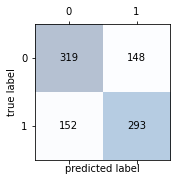

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       467
           1       0.66      0.66      0.66       445

    accuracy                           0.67       912
   macro avg       0.67      0.67      0.67       912
weighted avg       0.67      0.67      0.67       912



In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#pipe_svc.fit(X_train, y_train)
y_pred = model.predict(X_val)
confmat = confusion_matrix(y_true=y_val, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

print(classification_report(y_val, y_pred))

### Limitations

A possible problem with the data that was used is that some of the YouTube trailer views and likes may have happened after the movie was released. If trailers get watched more because movies are successful and not vice versa, this can be a problem. This would mean feedback or leaking of the target variable into our predictors.

Unfortunately, YouTube does not allow access to historical data about videos (creators can only get access to their own channel history after 2015). The only way to get this data would be to collect it on new movies before the release.

We do not think this problem is critical for two reasons. First, we hypothesize most trailer watches happen before the movie is released since they are released with much fanfare months in advance. Second, though some of the watch data undoubtedly comes after the release, it is not all caused by the popularity of the movie. Trailer likes and dislikes will be especially robust to this problem - though popularity may inflate view count, likes and dislikes are based on the quality of the trailer, so it does not matter if they come before or after release date.